In [1]:
%matplotlib inline

In [29]:
import os
import numpy as np
from keras import backend as K
from keras import optimizers
from keras.applications import inception_v3
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from PIL import Image

In [3]:
# Load pre-trained image recognition model
model = inception_v3.InceptionV3()

In [31]:
model = Sequential()
model.add(Convolution2D(32, (3, 3), input_shape=(150, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(25))
model.add(Activation('softmax'))

model.load_weights('../models/augmented_50_epochs.h5')

In [32]:
# Grab a reference to the first and last layer of the neural net
model_input_layer = model.layers[0].input
model_output_layer = model.layers[-1].output

In [74]:
# Choose an ImageNet object to fake
# The list of classes is available here: https://gist.github.com/ageitgey/4e1342c10a71981d0b491e1b8227328b
# Class #859 is "toaster"
object_type_to_fake = 7

In [75]:
# Load the image to hack
img = image.load_img("../data/validation/eiffel_tower/5865190445.jpg", target_size=(150, 150))
original_image = image.img_to_array(img)

In [76]:
# Scale the image so all pixel intensities are between [-1, 1] as the model expects
original_image /= 255.
original_image -= 0.5
original_image *= 2.

In [77]:
# Add a 4th dimension for batch size (as Keras expects)
original_image = np.expand_dims(original_image, axis=0)

In [78]:
# Pre-calculate the maximum change we will allow to the image
# We'll make sure our hacked image never goes past this so it doesn't look funny.
# A larger number produces an image faster but risks more distortion.
max_change_above = original_image + 0.01
max_change_below = original_image - 0.01

In [79]:
# Create a copy of the input image to hack on
hacked_image = np.copy(original_image)

In [80]:
# How much to update the hacked image in each iteration
learning_rate = 0.1

In [81]:
# Define the cost function.
# Our 'cost' will be the likelihood out image is the target class according to the pre-trained model
cost_function = model_output_layer[0, object_type_to_fake]

In [82]:
# We'll ask Keras to calculate the gradient based on the input image and the currently predicted class
# In this case, referring to "model_input_layer" will give us back image we are hacking.
gradient_function = K.gradients(cost_function, model_input_layer)[0]

In [83]:
# Create a Keras function that we can call to calculate the current cost and gradient
grab_cost_and_gradients_from_model = K.function([model_input_layer, K.learning_phase()], [cost_function, gradient_function])

In [84]:
cost = 0.0

In [85]:
# In a loop, keep adjusting the hacked image slightly so that it tricks the model more and more
# until it gets to at least 80% confidence
while cost < 0.80:
    # Check how close the image is to our target class and grab the gradients we
    # can use to push it one more step in that direction.
    # Note: It's really important to pass in '0' for the Keras learning mode here!
    # Keras layers behave differently in prediction vs. train modes!
    cost, gradients = grab_cost_and_gradients_from_model([hacked_image, 0])

    # Move the hacked image one step further towards fooling the model
    hacked_image += gradients * learning_rate

    # Ensure that the image doesn't ever change too much to either look funny or to become an invalid image
#     hacked_image = np.clip(hacked_image, max_change_below, max_change_above)
    hacked_image = np.clip(hacked_image, -1.0, 1.0)

    print("Model's predicted likelihood that the image is a toaster: {:.8}%".format(cost * 100))

Model's predicted likelihood that the image is a toaster: 56.513286%
Model's predicted likelihood that the image is a toaster: 59.436148%
Model's predicted likelihood that the image is a toaster: 62.197715%
Model's predicted likelihood that the image is a toaster: 64.794928%
Model's predicted likelihood that the image is a toaster: 67.208362%
Model's predicted likelihood that the image is a toaster: 69.428074%
Model's predicted likelihood that the image is a toaster: 71.497786%
Model's predicted likelihood that the image is a toaster: 73.383874%
Model's predicted likelihood that the image is a toaster: 75.112361%
Model's predicted likelihood that the image is a toaster: 76.692063%
Model's predicted likelihood that the image is a toaster: 78.119689%
Model's predicted likelihood that the image is a toaster: 79.419595%
Model's predicted likelihood that the image is a toaster: 80.600613%


In [86]:
# De-scale the image's pixels from [-1, 1] back to the [0, 255] range
img = hacked_image[0]
img /= 2.
img += 0.5
img *= 255.

In [87]:
# Save the hacked image!
im = Image.fromarray(img.astype(np.uint8))
im.save("hacked-image.png")

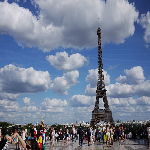

In [88]:
%matplotlib inline
pil_im = Image.open('hacked-image.png')
pil_im

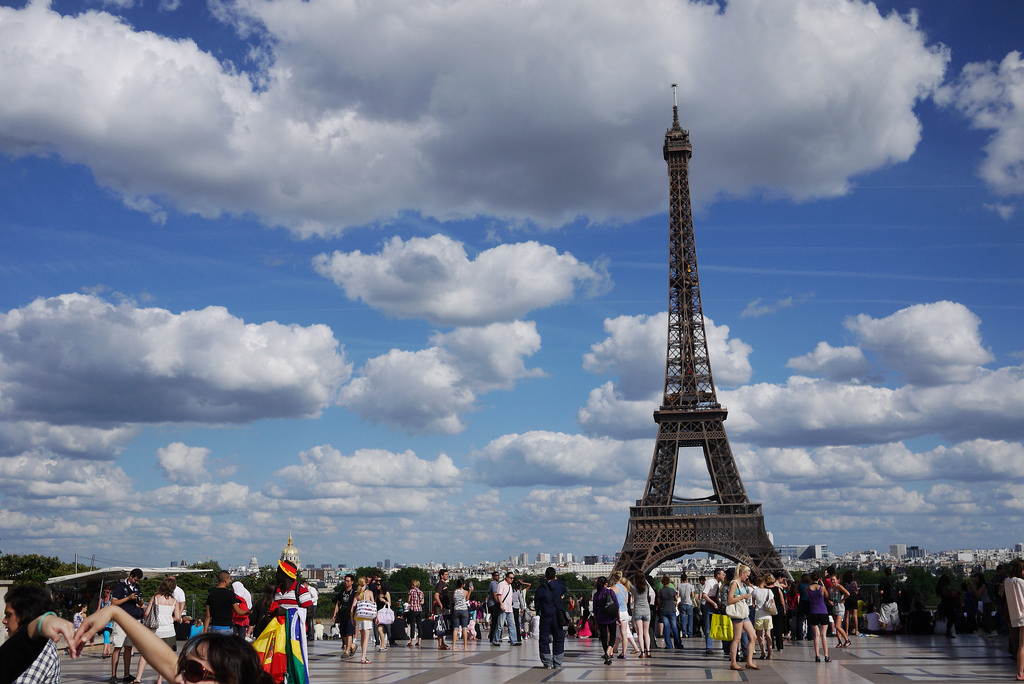

In [89]:
%matplotlib inline
pil_im = Image.open('../data/validation/eiffel_tower/5865190445.jpg')
pil_im